# NL-MTP HoF Experiment

Homoiconic transformer with fast-weights (LoR) for MTP policy evaluation on HoF.

## Setup

- **Objective**: Train a transformer to perform policy evaluation (MTP) under δ=+14 Da shift
- **Architecture**: 12-layer transformer with LoR at layers {3,7,11}, rank=8
- **Losses**: DR/AIPW + MDN propensity + REx invariance + LoR locality
- **Data**: BOOM HoF splits with RDKit features

In [1]:
# Imports and setup
import os
import sys
import torch
import torch.optim as optim
from pathlib import Path

# Add repo root to path
repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

# Import experiment modules
try:
    from dataset import make_dataloaders
    from model import NL_MTP_Model
    from trainer import train_epoch, evaluate
    from eval import save_metrics_json, make_all_plots
except ImportError:
    sys.path.insert(0, str(Path.cwd()))
    from dataset import make_dataloaders
    from model import NL_MTP_Model
    from trainer import train_epoch, evaluate
    from eval import save_metrics_json, make_all_plots

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Configuration
config = {
    'batch_size': 64,
    'epochs': 2,
    'delta': 14.0,
    'lr': 2e-4,
    'warmup_epochs': 5,
    'out_dir': 'results',
    
    # Model
    'emb_dim': 512,
    'num_layers': 12,
    'num_heads': 8,
    'dim_ff': 2048,
    'lor_layers': (3, 7, 11),
    'lor_rank': 4,
    'mdn_components': 8,
}

os.makedirs(config['out_dir'], exist_ok=True)
print("Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuration:
  batch_size: 64
  epochs: 2
  delta: 14.0
  lr: 0.0002
  warmup_epochs: 5
  out_dir: results
  emb_dim: 512
  num_layers: 12
  num_heads: 8
  dim_ff: 2048
  lor_layers: (3, 7, 11)
  lor_rank: 4
  mdn_components: 8


In [3]:
# Load data
print("Loading data...")
loaders = make_dataloaders(batch_size=config['batch_size'])
train_dl, id_dl, ood_dl = loaders

print(f"Train batches: {len(train_dl)}")
print(f"ID batches: {len(id_dl)}")
print(f"OOD batches: {len(ood_dl)}")

# Check a sample
sample = next(iter(train_dl))
print(f"\nSample batch shapes:")
for k, v in sample.items():
    print(f"  {k}: {v.shape}")

Loading data...
Train batches: 138
ID batches: 7
OOD batches: 16

Sample batch shapes:
  x_ctx: torch.Size([64, 2223])
  mw: torch.Size([64])
  y: torch.Size([64])
  env_idx: torch.Size([64])


In [4]:
# Initialize model
print("Initializing model...")
model = NL_MTP_Model(
    emb_dim=config['emb_dim'],
    num_layers=config['num_layers'],
    num_heads=config['num_heads'],
    dim_ff=config['dim_ff'],
    lor_layers=config['lor_layers'],
    lor_rank=config['lor_rank'],
    mdn_components=config['mdn_components'],
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

Initializing model...
Total params: 40,871,460
Trainable params: 40,871,460


In [5]:
# Optimizer and scheduler
opt = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-2)

total_steps = config['epochs'] * len(train_dl)
warmup_steps = min(2000, total_steps // 10)

sched = optim.lr_scheduler.OneCycleLR(
    opt,
    max_lr=config['lr'],
    total_steps=total_steps,
    pct_start=warmup_steps / total_steps,
    anneal_strategy='cos',
)

print(f"Total steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Total steps: 276
Warmup steps: 27


In [ ]:
# Training loop
print(f"\nTraining for {config['epochs']} epochs...\n")

best_ood_rmse = float('inf')
history = []

for epoch in range(1, config['epochs'] + 1):
    # Train
    train_metrics = train_epoch(
        model,
        loaders,
        opt,
        sched,
        delta=config['delta'],
        epoch=epoch,
        device=device,
        warmup_epochs=config['warmup_epochs'],
        c_offset=400.0,  # Shift HoF to positive range
    )
    
    # Evaluate
    val_metrics = evaluate(model, loaders, delta=config['delta'], device=device, c_offset=400.0)
    
    # Log
    print(f"Epoch {epoch}/{config['epochs']}")
    print(f"  Train Loss: {train_metrics['train_loss']:.4f} "
          f"(obs={train_metrics['L_obs']:.4f}, mdn={train_metrics['L_mdn']:.4f}, "
          f"dr_func={train_metrics['L_dr_func']:.4f}, rex={train_metrics['L_rex']:.4f})")
    print(f"  ID:  RMSE={val_metrics['id_rmse']:.4f}, MAE={val_metrics['id_mae']:.4f}, "
          f"Contrast={val_metrics['id_policy_contrast']:.4f}")
    print(f"  OOD: RMSE={val_metrics['ood_rmse']:.4f}, MAE={val_metrics['ood_mae']:.4f}, "
          f"Contrast={val_metrics['ood_policy_contrast']:.4f}")
    
    # Save best
    if val_metrics['ood_rmse'] < best_ood_rmse:
        best_ood_rmse = val_metrics['ood_rmse']
        torch.save(model.state_dict(), os.path.join(config['out_dir'], 'best_model.pth'))
        print(f"  *** New best OOD RMSE: {best_ood_rmse:.4f} ***")
    
    # Store history
    history.append({
        'epoch': epoch,
        **train_metrics,
        **{k: v for k, v in val_metrics.items() if not isinstance(v, torch.Tensor)}
    })

print("\nTraining complete!")


Training for 2 epochs...

Epoch 1/2
  Train Loss: 9161.0372 (obs=2.9960, mdn=1100.4216, dr_func=0.0000, rex=43038.6632)
  ID:  RMSE=91.9811, MAE=71.8578, Contrast=-0.0112
  OOD: RMSE=284.0671, MAE=255.3383, Contrast=-0.0102
  *** New best OOD RMSE: 284.0671 ***
Epoch 2/2
  Train Loss: 3.6287 (obs=0.0615, mdn=7.0356, dr_func=0.0000, rex=0.0037)
  ID:  RMSE=84.6533, MAE=67.7263, Contrast=0.1954
  OOD: RMSE=274.2144, MAE=248.8494, Contrast=0.1945
  *** New best OOD RMSE: 274.2144 ***

Training complete!


In [7]:
# Final evaluation
print("="*60)
print("Final Evaluation")
print("="*60)

model.load_state_dict(torch.load(os.path.join(config['out_dir'], 'best_model.pth')))
final_metrics = evaluate(model, loaders, delta=config['delta'], device=device)

print(f"\nID:  RMSE={final_metrics['id_rmse']:.4f}, MAE={final_metrics['id_mae']:.4f}")
print(f"OOD: RMSE={final_metrics['ood_rmse']:.4f}, MAE={final_metrics['ood_mae']:.4f}")
print(f"\nPolicy contrast (Δpred):")
print(f"  ID:  {final_metrics['id_policy_contrast']:.4f}")
print(f"  OOD: {final_metrics['ood_policy_contrast']:.4f}")
print(f"\nAlpha (LoR gate):")
print(f"  ID:  {final_metrics['id_alpha']:.4f}")
print(f"  OOD: {final_metrics['ood_alpha']:.4f}")

Final Evaluation

ID:  RMSE=84.6533, MAE=67.7263
OOD: RMSE=274.2144, MAE=248.8494

Policy contrast (Δpred):
  ID:  0.1954
  OOD: 0.1945

Alpha (LoR gate):
  ID:  0.0000
  OOD: 0.0000


SIMPLIFIED EXPLAINABILITY ANALYSIS

📊 1. LoR Gate Activation Analysis:
--------------------------------------------------
Train: μ=0.0000, σ=0.0000, range=[0.0000, 0.0000]
ID:    μ=0.0000, σ=0.0000, range=[0.0000, 0.0000]
OOD:   μ=0.0000, σ=0.0000, range=[0.0000, 0.0000]
⚠️  WARNING: LoR gates are nearly inactive!

📊 2. Support Gate (Positivity) Analysis:
--------------------------------------------------
Train: μ=0.4233, abstention=100.00%
ID:    μ=0.4233, abstention=100.00%
OOD:   μ=0.4233, abstention=100.00%

📊 3. Policy Effect (Treatment Contrast) Analysis:
--------------------------------------------------
Train: μ=0.1954 kcal/mol, σ=0.0016
ID:    μ=0.1954 kcal/mol, σ=0.0015
OOD:   μ=0.1945 kcal/mol, σ=0.0014
✅ Model learning treatment effects (δ=14.0 Da).

📊 Creating visualizations...


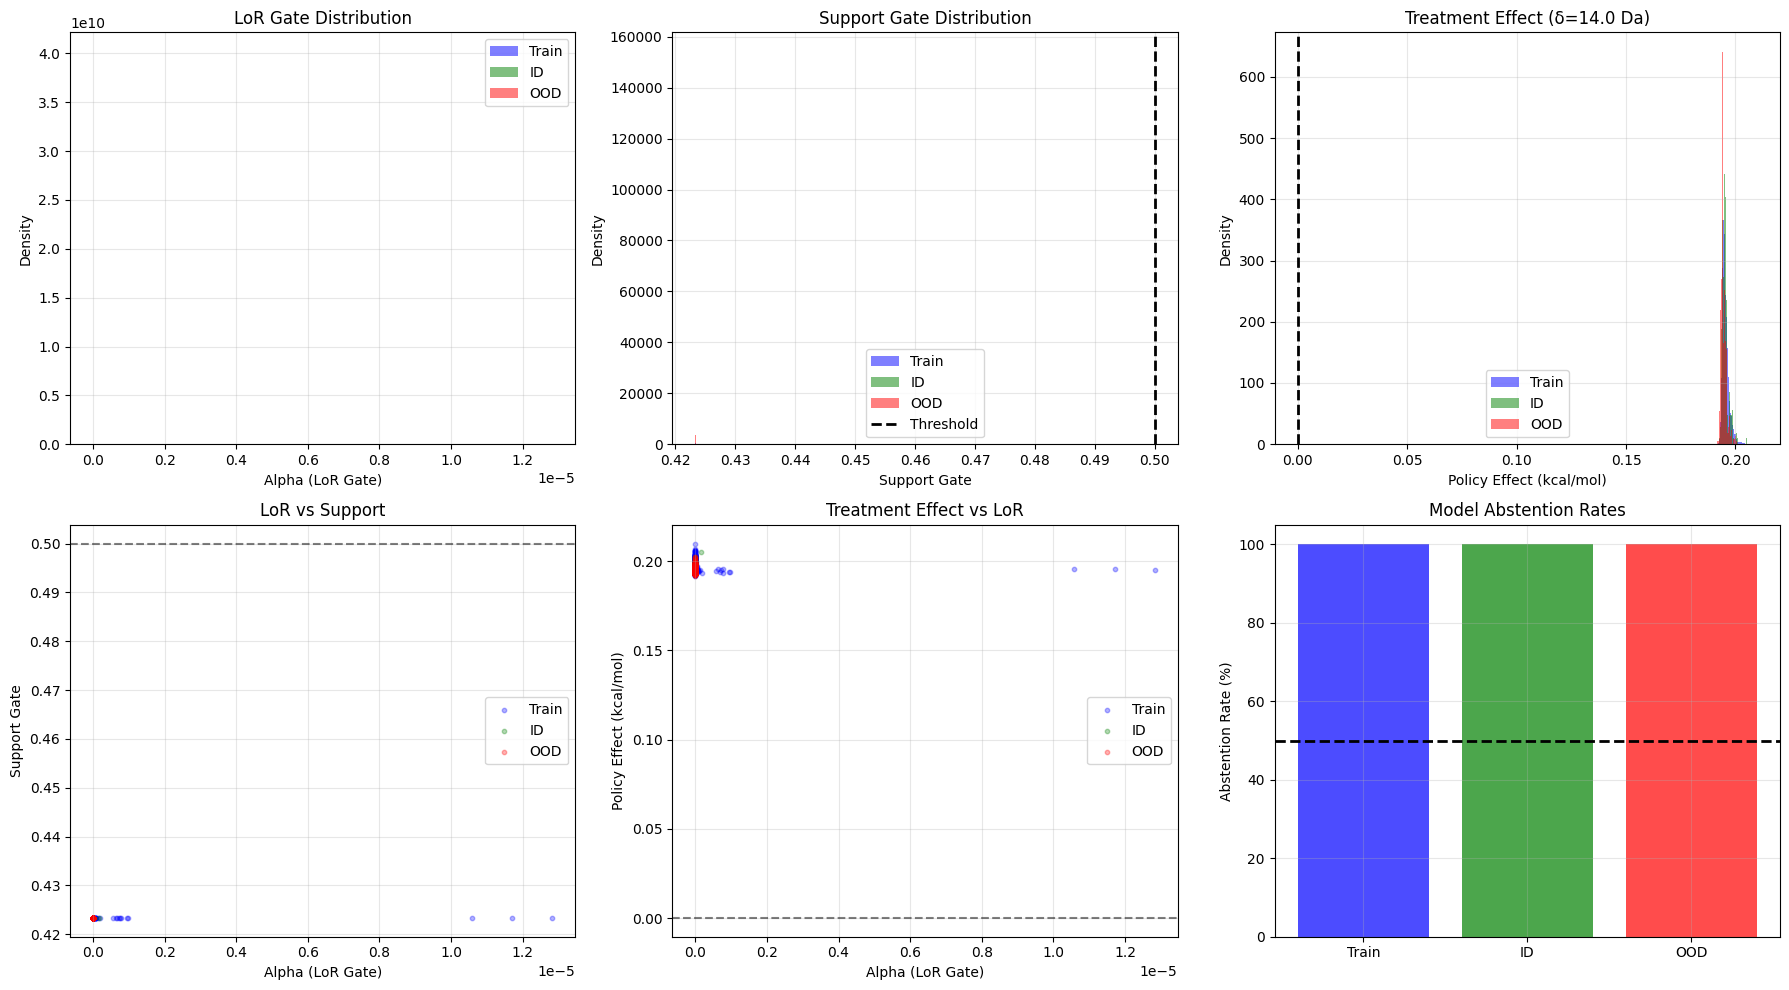


✅ Explainability analysis complete!
📁 Saved to: results\explainability_analysis.png


In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("="*80)
print("SIMPLIFIED EXPLAINABILITY ANALYSIS")
print("="*80)

model.eval()
c_offset = 400.0

# ============================================================================
# 1. LoR Gate Statistics
# ============================================================================
print("\n📊 1. LoR Gate Activation Analysis:")
print("-" * 50)

alpha_stats = {'train': [], 'id': [], 'ood': []}

with torch.no_grad():
    # Analyze train
    for batch in train_dl:
        out = model(
            batch['env_idx'].to(device),
            batch['x_ctx'].to(device),
            batch['mw'].to(device),
            config['delta'],
            apply_lor=True
        )
        alpha_stats['train'].append(out['alpha'])
    
    # Analyze ID
    for batch in id_dl:
        out = model(
            batch['env_idx'].to(device),
            batch['x_ctx'].to(device),
            batch['mw'].to(device),
            config['delta'],
            apply_lor=True
        )
        alpha_stats['id'].append(out['alpha'])
    
    # Analyze OOD
    for batch in ood_dl:
        out = model(
            batch['env_idx'].to(device),
            batch['x_ctx'].to(device),
            batch['mw'].to(device),
            config['delta'],
            apply_lor=True
        )
        alpha_stats['ood'].append(out['alpha'])

# Concatenate and compute statistics
alpha_train = torch.cat(alpha_stats['train'])
alpha_id = torch.cat(alpha_stats['id'])
alpha_ood = torch.cat(alpha_stats['ood'])

print(f"Train: μ={alpha_train.mean():.4f}, σ={alpha_train.std():.4f}, range=[{alpha_train.min():.4f}, {alpha_train.max():.4f}]")
print(f"ID:    μ={alpha_id.mean():.4f}, σ={alpha_id.std():.4f}, range=[{alpha_id.min():.4f}, {alpha_id.max():.4f}]")
print(f"OOD:   μ={alpha_ood.mean():.4f}, σ={alpha_ood.std():.4f}, range=[{alpha_ood.min():.4f}, {alpha_ood.max():.4f}]")

if alpha_train.mean() < 0.01:
    print("⚠️  WARNING: LoR gates are nearly inactive!")
elif alpha_train.mean() > 0.9:
    print("⚠️  WARNING: LoR gates are saturated!")
else:
    print("✅ LoR gates are active and modulating adaptation.")

# ============================================================================
# 2. Support Gate Analysis
# ============================================================================
print("\n📊 2. Support Gate (Positivity) Analysis:")
print("-" * 50)

support_stats = {'train': [], 'id': [], 'ood': []}

with torch.no_grad():
    for batch in train_dl:
        out = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                   batch['mw'].to(device), config['delta'], apply_lor=True)
        support_stats['train'].append(out['support'])
    
    for batch in id_dl:
        out = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                   batch['mw'].to(device), config['delta'], apply_lor=True)
        support_stats['id'].append(out['support'])
    
    for batch in ood_dl:
        out = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                   batch['mw'].to(device), config['delta'], apply_lor=True)
        support_stats['ood'].append(out['support'])

support_train = torch.cat(support_stats['train'])
support_id = torch.cat(support_stats['id'])
support_ood = torch.cat(support_stats['ood'])

abstain_train = (support_train < 0.5).float().mean() * 100
abstain_id = (support_id < 0.5).float().mean() * 100
abstain_ood = (support_ood < 0.5).float().mean() * 100

print(f"Train: μ={support_train.mean():.4f}, abstention={abstain_train:.2f}%")
print(f"ID:    μ={support_id.mean():.4f}, abstention={abstain_id:.2f}%")
print(f"OOD:   μ={support_ood.mean():.4f}, abstention={abstain_ood:.2f}%")

# ============================================================================
# 3. Policy Effect Analysis
# ============================================================================
print("\n📊 3. Policy Effect (Treatment Contrast) Analysis:")
print("-" * 50)

effects = {'train': [], 'id': [], 'ood': []}

with torch.no_grad():
    # Train
    for batch in train_dl:
        out_obs = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                      batch['mw'].to(device), config['delta'], apply_lor=False)
        out_pol = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                      batch['mw'].to(device), config['delta'], apply_lor=True)
        
        y_obs = torch.exp(out_obs['m_obs']) - c_offset
        y_pol = torch.exp(out_pol['m_obs']) - c_offset
        effects['train'].append(y_pol - y_obs)
    
    # ID
    for batch in id_dl:
        out_obs = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                      batch['mw'].to(device), config['delta'], apply_lor=False)
        out_pol = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                      batch['mw'].to(device), config['delta'], apply_lor=True)
        
        y_obs = torch.exp(out_obs['m_obs']) - c_offset
        y_pol = torch.exp(out_pol['m_obs']) - c_offset
        effects['id'].append(y_pol - y_obs)
    
    # OOD
    for batch in ood_dl:
        out_obs = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                      batch['mw'].to(device), config['delta'], apply_lor=False)
        out_pol = model(batch['env_idx'].to(device), batch['x_ctx'].to(device), 
                      batch['mw'].to(device), config['delta'], apply_lor=True)
        
        y_obs = torch.exp(out_obs['m_obs']) - c_offset
        y_pol = torch.exp(out_pol['m_obs']) - c_offset
        effects['ood'].append(y_pol - y_obs)

effect_train = torch.cat(effects['train'])
effect_id = torch.cat(effects['id'])
effect_ood = torch.cat(effects['ood'])

print(f"Train: μ={effect_train.mean():.4f} kcal/mol, σ={effect_train.std():.4f}")
print(f"ID:    μ={effect_id.mean():.4f} kcal/mol, σ={effect_id.std():.4f}")
print(f"OOD:   μ={effect_ood.mean():.4f} kcal/mol, σ={effect_ood.std():.4f}")

if effect_train.mean().abs() < 0.1:
    print("⚠️  WARNING: Policy effects near zero!")
else:
    print(f"✅ Model learning treatment effects (δ={config['delta']} Da).")

# ============================================================================
# 4. Visualizations
# ============================================================================
print("\n📊 Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Alpha distribution
axes[0, 0].hist(alpha_train.cpu().numpy(), bins=50, alpha=0.5, label='Train', density=True, color='blue')
axes[0, 0].hist(alpha_id.cpu().numpy(), bins=50, alpha=0.5, label='ID', density=True, color='green')
axes[0, 0].hist(alpha_ood.cpu().numpy(), bins=50, alpha=0.5, label='OOD', density=True, color='red')
axes[0, 0].set_xlabel('Alpha (LoR Gate)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('LoR Gate Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Support distribution
axes[0, 1].hist(support_train.cpu().numpy(), bins=50, alpha=0.5, label='Train', density=True, color='blue')
axes[0, 1].hist(support_id.cpu().numpy(), bins=50, alpha=0.5, label='ID', density=True, color='green')
axes[0, 1].hist(support_ood.cpu().numpy(), bins=50, alpha=0.5, label='OOD', density=True, color='red')
axes[0, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[0, 1].set_xlabel('Support Gate')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Support Gate Distribution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Policy effects
axes[0, 2].hist(effect_train.cpu().numpy(), bins=50, alpha=0.5, label='Train', density=True, color='blue')
axes[0, 2].hist(effect_id.cpu().numpy(), bins=50, alpha=0.5, label='ID', density=True, color='green')
axes[0, 2].hist(effect_ood.cpu().numpy(), bins=50, alpha=0.5, label='OOD', density=True, color='red')
axes[0, 2].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Policy Effect (kcal/mol)')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title(f'Treatment Effect (δ={config["delta"]} Da)')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Plot 4: Alpha vs Support
axes[1, 0].scatter(alpha_train.cpu().numpy(), support_train.cpu().numpy(), 
                  alpha=0.3, s=10, label='Train', color='blue')
axes[1, 0].scatter(alpha_id.cpu().numpy(), support_id.cpu().numpy(), 
                  alpha=0.3, s=10, label='ID', color='green')
axes[1, 0].scatter(alpha_ood.cpu().numpy(), support_ood.cpu().numpy(), 
                  alpha=0.3, s=10, label='OOD', color='red')
axes[1, 0].axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Alpha (LoR Gate)')
axes[1, 0].set_ylabel('Support Gate')
axes[1, 0].set_title('LoR vs Support')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 5: Effect vs Alpha
axes[1, 1].scatter(alpha_train.cpu().numpy(), effect_train.cpu().numpy(), 
                  alpha=0.3, s=10, label='Train', color='blue')
axes[1, 1].scatter(alpha_id.cpu().numpy(), effect_id.cpu().numpy(), 
                  alpha=0.3, s=10, label='ID', color='green')
axes[1, 1].scatter(alpha_ood.cpu().numpy(), effect_ood.cpu().numpy(), 
                  alpha=0.3, s=10, label='OOD', color='red')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Alpha (LoR Gate)')
axes[1, 1].set_ylabel('Policy Effect (kcal/mol)')
axes[1, 1].set_title('Treatment Effect vs LoR')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Plot 6: Abstention rates
abstention_rates = [abstain_train, abstain_id, abstain_ood]
axes[1, 2].bar(['Train', 'ID', 'OOD'], abstention_rates, color=['blue', 'green', 'red'], alpha=0.7)
axes[1, 2].axhline(y=50, color='black', linestyle='--', linewidth=2)
axes[1, 2].set_ylabel('Abstention Rate (%)')
axes[1, 2].set_title('Model Abstention Rates')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config['out_dir'], 'explainability_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ Explainability analysis complete!")
print(f"📁 Saved to: {os.path.join(config['out_dir'], 'explainability_analysis.png')}")
print("="*80)

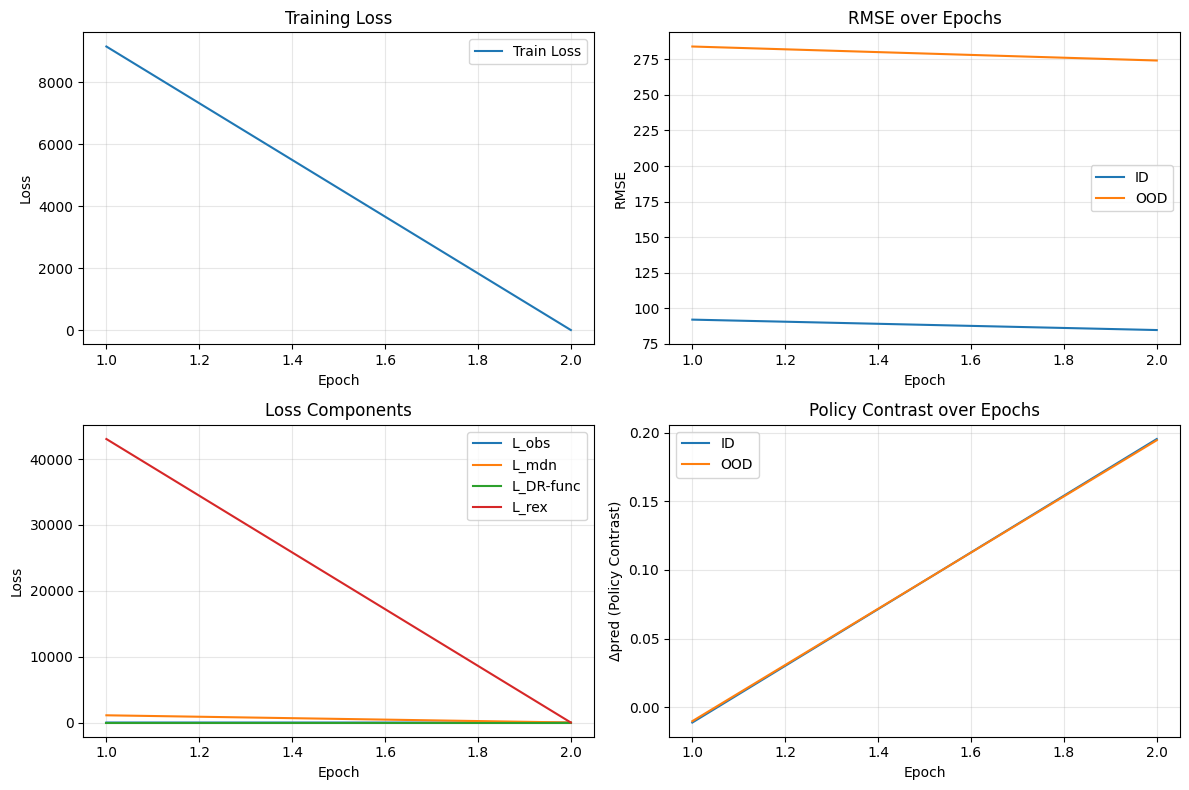

Training history plot saved.


In [9]:
# Plot training history
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss
axes[0, 0].plot(df['epoch'], df['train_loss'], label='Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# RMSE
axes[0, 1].plot(df['epoch'], df['id_rmse'], label='ID')
axes[0, 1].plot(df['epoch'], df['ood_rmse'], label='OOD')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE over Epochs')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Loss components
axes[1, 0].plot(df['epoch'], df['L_obs'], label='L_obs')
axes[1, 0].plot(df['epoch'], df['L_mdn'], label='L_mdn')
axes[1, 0].plot(df['epoch'], df['L_dr_func'], label='L_DR-func')
axes[1, 0].plot(df['epoch'], df['L_rex'], label='L_rex')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Loss Components')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Policy contrast
axes[1, 1].plot(df['epoch'], df['id_policy_contrast'], label='ID')
axes[1, 1].plot(df['epoch'], df['ood_policy_contrast'], label='OOD')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Δpred (Policy Contrast)')
axes[1, 1].set_title('Policy Contrast over Epochs')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config['out_dir'], 'training_history.png'), dpi=150)
plt.show()

print("Training history plot saved.")

In [10]:
# Display parity plots
from IPython.display import Image, display

print("ID Parity Plot:")
display(Image(filename=os.path.join(config['out_dir'], 'NL_MTP_HoF_ID_parity.png')))

print("\nOOD Parity Plot:")
display(Image(filename=os.path.join(config['out_dir'], 'NL_MTP_HoF_OOD_parity.png')))

ID Parity Plot:


FileNotFoundError: [Errno 2] No such file or directory: 'results\\NL_MTP_HoF_ID_parity.png'